In [1]:
import wfdb
import numpy as np
import pandas as pd
import scipy.signal
import os
from sklearn.ensemble import RandomForestClassifier, VotingClassifier, StackingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, make_scorer, f1_score
from sklearn.multioutput import MultiOutputClassifier
from tqdm import tqdm
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

In [ ]:
LABELS = ["H", "HA", "OA", "X", "CA", "CAA", "L", "LA", "A", "W", "1", "2", "3", "4", "R"]
DATA_DIR = "../data/"

def read_signals(record_name):
    record = wfdb.rdrecord(record_name)
    return record.p_signal, record.sig_name, record.fs

def extract_features(signal, fs):
    f, psd = scipy.signal.welch(signal, fs=fs)
    return {
        'mean': np.mean(signal),
        'std': np.std(signal),
        'max': np.max(signal),
        'min': np.min(signal),
        'power': np.sum(psd)
    }

def process_data(record_name, window_size=30):
    signals, signal_names, fs = read_signals(record_name)
    annotation = wfdb.rdann(record_name, 'st')
    segment_length = int(fs * window_size)

    data, labels = [], []

    for i in range(0, len(signals) - segment_length + 1, segment_length):
        segment_features = {}
        for j, signal_name in enumerate(signal_names):
            features = extract_features(signals[i:i+segment_length, j], fs)
            segment_features.update({f"{signal_name}_{k}": v for k, v in features.items()})

        segment_labels = {label: 0 for label in LABELS}
        for ann_time, ann_note in zip(annotation.sample, annotation.aux_note):
            if i <= ann_time < i + segment_length:
                for label in LABELS:
                    if label in ann_note:
                        segment_labels[label] = 1

        data.append(segment_features)
        labels.append(segment_labels)

    df = pd.DataFrame(data)
    df_labels = pd.DataFrame(labels)
    return pd.concat([df, df_labels], axis=1)

# Step 1: Load and process data
record_names = [
    "slp01a", "slp01b", "slp02a", "slp02b", "slp03", "slp04",
    "slp14", "slp16", "slp32", "slp37", "slp41", "slp45",
    "slp48", "slp59", "slp60", "slp61", "slp66", "slp67x"
]

dfs = []
print("\n🔍 Extracting features from records...")
for record in tqdm(record_names):
    rec_path = os.path.join(DATA_DIR, record)
    df = process_data(rec_path)
    df.to_csv(f"{record}_features.csv", index=False)
    dfs.append(df)

df_all = pd.concat(dfs, ignore_index=True).fillna(0)

# Step 2: Feature and label split
X = df_all.drop(columns=LABELS)
y = df_all[LABELS]

# Step 3: Normalize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Step 4: Train/test split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Step 5: Define individual models with GPU acceleration
rf = RandomForestClassifier(n_estimators=500, max_depth=40, random_state=42, n_jobs=4)

mlp = MLPClassifier(hidden_layer_sizes=(512, 256, 128), activation='relu', solver='adam',
                    max_iter=600, early_stopping=True, random_state=42)  # CPU only

xgb = XGBClassifier(n_estimators=300, learning_rate=0.05, max_depth=10,
                    tree_method='gpu_hist', predictor='gpu_predictor',
                    use_label_encoder=False, eval_metric='logloss', verbosity=0)

lgb = LGBMClassifier(n_estimators=300, learning_rate=0.05, num_leaves=64,
                     device='gpu', gpu_platform_id=0, gpu_device_id=0, random_state=42)

# Step 6: Stacking classifier with these GPU-accelerated base models
base_learners = [
    ('rf', rf),     # CPU
    ('mlp', mlp),   # CPU
    ('xgb', xgb),   # GPU
    ('lgb', lgb)    # GPU
]

meta_learner = RandomForestClassifier(n_estimators=200, max_depth=10, random_state=42, n_jobs=4)

# Step 7: MultiOutputClassifier wrapping StackingClassifier
stacking_ensemble = MultiOutputClassifier(
    StackingClassifier(
        estimators=[
            base_learners           # limit XGB threads
        ],
        final_estimator=meta_learner,           # or any light model
        passthrough=True,
        n_jobs=1  # very important to keep this low or 1
    ),
    n_jobs=1  # avoid over-parallelization here too
)



🔍 Extracting features from records...


100%|██████████| 18/18 [00:25<00:00,  1.44s/it]


In [6]:
stacking_ensemble.fit(X_train, y_train)

c:\Users\prana\anaconda3\envs\tds\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[LightGBM] [Info] Number of positive: 790, number of negative: 7429
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006250 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 15707
[LightGBM] [Info] Number of data points in the train set: 8219, number of used features: 75
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.096119 -> initscore=-2.241114
[LightGBM] [Info] Start training from score -2.241114


c:\Users\prana\anaconda3\envs\tds\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\prana\anaconda3\envs\tds\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[LightGBM] [Info] Number of positive: 632, number of negative: 5943
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001613 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 15168
[LightGBM] [Info] Number of data points in the train set: 6575, number of used features: 75
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.096122 -> initscore=-2.241080
[LightGBM] [Info] Start training from score -2.241080


c:\Users\prana\anaconda3\envs\tds\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 632, number of negative: 5943
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001613 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 15163
[LightGBM] [Info] Number of data points in the train set: 6575, number of used features: 75
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.096122 -> initscore=-2.241080
[LightGBM] [Info] Start training from score -2.241080


c:\Users\prana\anaconda3\envs\tds\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 632, number of negative: 5943
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001536 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 15207
[LightGBM] [Info] Number of data points in the train set: 6575, number of used features: 75
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.096122 -> initscore=-2.241080
[LightGBM] [Info] Start training from score -2.241080


c:\Users\prana\anaconda3\envs\tds\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 632, number of negative: 5943
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001577 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 15235
[LightGBM] [Info] Number of data points in the train set: 6575, number of used features: 75
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.096122 -> initscore=-2.241080
[LightGBM] [Info] Start training from score -2.241080


c:\Users\prana\anaconda3\envs\tds\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 632, number of negative: 5944
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001523 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 15190
[LightGBM] [Info] Number of data points in the train set: 6576, number of used features: 75
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.096107 -> initscore=-2.241248
[LightGBM] [Info] Start training from score -2.241248


c:\Users\prana\anaconda3\envs\tds\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 588, number of negative: 7631
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001875 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 15707
[LightGBM] [Info] Number of data points in the train set: 8219, number of used features: 75
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.071542 -> initscore=-2.563247
[LightGBM] [Info] Start training from score -2.563247


c:\Users\prana\anaconda3\envs\tds\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\prana\anaconda3\envs\tds\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\prana\anaconda3\envs\tds\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[LightGBM] [Info] Number of positive: 471, number of negative: 6104
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001633 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 15162
[LightGBM] [Info] Number of data points in the train set: 6575, number of used features: 75
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.071635 -> initscore=-2.561841
[LightGBM] [Info] Start training from score -2.561841


c:\Users\prana\anaconda3\envs\tds\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 470, number of negative: 6105
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001572 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 15166
[LightGBM] [Info] Number of data points in the train set: 6575, number of used features: 75
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.071483 -> initscore=-2.564131
[LightGBM] [Info] Start training from score -2.564131


c:\Users\prana\anaconda3\envs\tds\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 470, number of negative: 6105
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002615 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 15209
[LightGBM] [Info] Number of data points in the train set: 6575, number of used features: 75
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.071483 -> initscore=-2.564131
[LightGBM] [Info] Start training from score -2.564131


c:\Users\prana\anaconda3\envs\tds\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 470, number of negative: 6105
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002266 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 15237
[LightGBM] [Info] Number of data points in the train set: 6575, number of used features: 75
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.071483 -> initscore=-2.564131
[LightGBM] [Info] Start training from score -2.564131


c:\Users\prana\anaconda3\envs\tds\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 471, number of negative: 6105
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003246 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 15183
[LightGBM] [Info] Number of data points in the train set: 6576, number of used features: 75
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.071624 -> initscore=-2.562005
[LightGBM] [Info] Start training from score -2.562005


c:\Users\prana\anaconda3\envs\tds\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 467, number of negative: 7752
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001918 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 15707
[LightGBM] [Info] Number of data points in the train set: 8219, number of used features: 75
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.056820 -> initscore=-2.809377
[LightGBM] [Info] Start training from score -2.809377


c:\Users\prana\anaconda3\envs\tds\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\prana\anaconda3\envs\tds\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\prana\anaconda3\envs\tds\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[LightGBM] [Info] Number of positive: 374, number of negative: 6201
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001476 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 15184
[LightGBM] [Info] Number of data points in the train set: 6575, number of used features: 75
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.056882 -> initscore=-2.808210
[LightGBM] [Info] Start training from score -2.808210


c:\Users\prana\anaconda3\envs\tds\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 374, number of negative: 6201
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001796 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 15162
[LightGBM] [Info] Number of data points in the train set: 6575, number of used features: 75
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.056882 -> initscore=-2.808210
[LightGBM] [Info] Start training from score -2.808210


c:\Users\prana\anaconda3\envs\tds\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 373, number of negative: 6202
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001491 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 15209
[LightGBM] [Info] Number of data points in the train set: 6575, number of used features: 75
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.056730 -> initscore=-2.811049
[LightGBM] [Info] Start training from score -2.811049


c:\Users\prana\anaconda3\envs\tds\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 373, number of negative: 6202
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001526 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 15245
[LightGBM] [Info] Number of data points in the train set: 6575, number of used features: 75
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.056730 -> initscore=-2.811049
[LightGBM] [Info] Start training from score -2.811049


c:\Users\prana\anaconda3\envs\tds\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 374, number of negative: 6202
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001498 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 15181
[LightGBM] [Info] Number of data points in the train set: 6576, number of used features: 75
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.056873 -> initscore=-2.808371
[LightGBM] [Info] Start training from score -2.808371


c:\Users\prana\anaconda3\envs\tds\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\prana\anaconda3\envs\tds\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[LightGBM] [Info] Number of positive: 1247, number of negative: 6972
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001904 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 15707
[LightGBM] [Info] Number of data points in the train set: 8219, number of used features: 75
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.151722 -> initscore=-1.721161
[LightGBM] [Info] Start training from score -1.721161


c:\Users\prana\anaconda3\envs\tds\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\prana\anaconda3\envs\tds\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\prana\anaconda3\envs\tds\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\prana\anaconda3\envs\tds\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[LightGBM] [Info] Number of positive: 997, number of negative: 5578
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001517 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 15186
[LightGBM] [Info] Number of data points in the train set: 6575, number of used features: 75
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.151635 -> initscore=-1.721835
[LightGBM] [Info] Start training from score -1.721835


c:\Users\prana\anaconda3\envs\tds\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 997, number of negative: 5578
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001519 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 15162
[LightGBM] [Info] Number of data points in the train set: 6575, number of used features: 75
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.151635 -> initscore=-1.721835
[LightGBM] [Info] Start training from score -1.721835


c:\Users\prana\anaconda3\envs\tds\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 998, number of negative: 5577
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001548 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 15204
[LightGBM] [Info] Number of data points in the train set: 6575, number of used features: 75
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.151787 -> initscore=-1.720653
[LightGBM] [Info] Start training from score -1.720653


c:\Users\prana\anaconda3\envs\tds\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 998, number of negative: 5577
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001510 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 15241
[LightGBM] [Info] Number of data points in the train set: 6575, number of used features: 75
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.151787 -> initscore=-1.720653
[LightGBM] [Info] Start training from score -1.720653


c:\Users\prana\anaconda3\envs\tds\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 998, number of negative: 5578
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001505 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 15184
[LightGBM] [Info] Number of data points in the train set: 6576, number of used features: 75
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.151764 -> initscore=-1.720832
[LightGBM] [Info] Start training from score -1.720832


c:\Users\prana\anaconda3\envs\tds\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 184, number of negative: 8035
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002913 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 15707
[LightGBM] [Info] Number of data points in the train set: 8219, number of used features: 75
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.022387 -> initscore=-3.776627
[LightGBM] [Info] Start training from score -3.776627


c:\Users\prana\anaconda3\envs\tds\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\prana\anaconda3\envs\tds\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\prana\anaconda3\envs\tds\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[LightGBM] [Info] Number of positive: 147, number of negative: 6428
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002258 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 15183
[LightGBM] [Info] Number of data points in the train set: 6575, number of used features: 75
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.022357 -> initscore=-3.777986
[LightGBM] [Info] Start training from score -3.777986


c:\Users\prana\anaconda3\envs\tds\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 147, number of negative: 6428
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002410 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 15160
[LightGBM] [Info] Number of data points in the train set: 6575, number of used features: 75
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.022357 -> initscore=-3.777986
[LightGBM] [Info] Start training from score -3.777986


c:\Users\prana\anaconda3\envs\tds\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 147, number of negative: 6428
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002525 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 15211
[LightGBM] [Info] Number of data points in the train set: 6575, number of used features: 75
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.022357 -> initscore=-3.777986
[LightGBM] [Info] Start training from score -3.777986


c:\Users\prana\anaconda3\envs\tds\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 147, number of negative: 6428
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002316 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 15242
[LightGBM] [Info] Number of data points in the train set: 6575, number of used features: 75
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.022357 -> initscore=-3.777986
[LightGBM] [Info] Start training from score -3.777986


c:\Users\prana\anaconda3\envs\tds\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 148, number of negative: 6428
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002422 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 15180
[LightGBM] [Info] Number of data points in the train set: 6576, number of used features: 75
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.022506 -> initscore=-3.771206
[LightGBM] [Info] Start training from score -3.771206


c:\Users\prana\anaconda3\envs\tds\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 137, number of negative: 8082
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001968 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 15707
[LightGBM] [Info] Number of data points in the train set: 8219, number of used features: 75
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.016669 -> initscore=-4.077414
[LightGBM] [Info] Start training from score -4.077414


c:\Users\prana\anaconda3\envs\tds\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\prana\anaconda3\envs\tds\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[LightGBM] [Info] Number of positive: 110, number of negative: 6465
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001486 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 15184
[LightGBM] [Info] Number of data points in the train set: 6575, number of used features: 75
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.016730 -> initscore=-4.073678
[LightGBM] [Info] Start training from score -4.073678


c:\Users\prana\anaconda3\envs\tds\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 110, number of negative: 6465
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001490 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 15160
[LightGBM] [Info] Number of data points in the train set: 6575, number of used features: 75
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.016730 -> initscore=-4.073678
[LightGBM] [Info] Start training from score -4.073678


c:\Users\prana\anaconda3\envs\tds\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 109, number of negative: 6466
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001638 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 15208
[LightGBM] [Info] Number of data points in the train set: 6575, number of used features: 75
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.016578 -> initscore=-4.082965
[LightGBM] [Info] Start training from score -4.082965


c:\Users\prana\anaconda3\envs\tds\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 109, number of negative: 6466
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001518 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 15245
[LightGBM] [Info] Number of data points in the train set: 6575, number of used features: 75
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.016578 -> initscore=-4.082965
[LightGBM] [Info] Start training from score -4.082965


c:\Users\prana\anaconda3\envs\tds\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 110, number of negative: 6466
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001532 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 15180
[LightGBM] [Info] Number of data points in the train set: 6576, number of used features: 75
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.016727 -> initscore=-4.073833
[LightGBM] [Info] Start training from score -4.073833


c:\Users\prana\anaconda3\envs\tds\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 369, number of negative: 7850
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001957 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 15707
[LightGBM] [Info] Number of data points in the train set: 8219, number of used features: 75
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.044896 -> initscore=-3.057472
[LightGBM] [Info] Start training from score -3.057472


c:\Users\prana\anaconda3\envs\tds\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\prana\anaconda3\envs\tds\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[LightGBM] [Info] Number of positive: 295, number of negative: 6280
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001455 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 15183
[LightGBM] [Info] Number of data points in the train set: 6575, number of used features: 75
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.044867 -> initscore=-3.058150
[LightGBM] [Info] Start training from score -3.058150


c:\Users\prana\anaconda3\envs\tds\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 295, number of negative: 6280
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001506 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 15157
[LightGBM] [Info] Number of data points in the train set: 6575, number of used features: 75
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.044867 -> initscore=-3.058150
[LightGBM] [Info] Start training from score -3.058150


c:\Users\prana\anaconda3\envs\tds\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 295, number of negative: 6280
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001454 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 15207
[LightGBM] [Info] Number of data points in the train set: 6575, number of used features: 75
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.044867 -> initscore=-3.058150
[LightGBM] [Info] Start training from score -3.058150


c:\Users\prana\anaconda3\envs\tds\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 295, number of negative: 6280
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001474 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 15241
[LightGBM] [Info] Number of data points in the train set: 6575, number of used features: 75
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.044867 -> initscore=-3.058150
[LightGBM] [Info] Start training from score -3.058150


c:\Users\prana\anaconda3\envs\tds\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 296, number of negative: 6280
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001518 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 15189
[LightGBM] [Info] Number of data points in the train set: 6576, number of used features: 75
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.045012 -> initscore=-3.054766
[LightGBM] [Info] Start training from score -3.054766


c:\Users\prana\anaconda3\envs\tds\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 161, number of negative: 8058
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002065 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 15707
[LightGBM] [Info] Number of data points in the train set: 8219, number of used features: 75
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.019589 -> initscore=-3.913016
[LightGBM] [Info] Start training from score -3.913016
[LightGBM] [Info] Number of positive: 129, number of negative: 6446
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001539 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 15188
[LightGBM] [Info] Number of data points in the train set: 6575, number of used features: 75
[LightGBM] [Info] [binar

c:\Users\prana\anaconda3\envs\tds\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 129, number of negative: 6446
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001493 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 15156
[LightGBM] [Info] Number of data points in the train set: 6575, number of used features: 75
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.019620 -> initscore=-3.911403
[LightGBM] [Info] Start training from score -3.911403


c:\Users\prana\anaconda3\envs\tds\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 129, number of negative: 6446
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001454 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 15211
[LightGBM] [Info] Number of data points in the train set: 6575, number of used features: 75
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.019620 -> initscore=-3.911403
[LightGBM] [Info] Start training from score -3.911403


c:\Users\prana\anaconda3\envs\tds\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 128, number of negative: 6447
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001434 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 15240
[LightGBM] [Info] Number of data points in the train set: 6575, number of used features: 75
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.019468 -> initscore=-3.919340
[LightGBM] [Info] Start training from score -3.919340


c:\Users\prana\anaconda3\envs\tds\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 129, number of negative: 6447
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001443 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 15185
[LightGBM] [Info] Number of data points in the train set: 6576, number of used features: 75
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.019617 -> initscore=-3.911558
[LightGBM] [Info] Start training from score -3.911558


c:\Users\prana\anaconda3\envs\tds\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 1418, number of negative: 6801
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001828 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 15707
[LightGBM] [Info] Number of data points in the train set: 8219, number of used features: 75
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.172527 -> initscore=-1.567822
[LightGBM] [Info] Start training from score -1.567822


c:\Users\prana\anaconda3\envs\tds\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\prana\anaconda3\envs\tds\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\prana\anaconda3\envs\tds\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\prana\anaconda3\envs\tds\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[LightGBM] [Info] Number of positive: 1135, number of negative: 5440
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001465 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 15182
[LightGBM] [Info] Number of data points in the train set: 6575, number of used features: 75
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.172624 -> initscore=-1.567146
[LightGBM] [Info] Start training from score -1.567146


c:\Users\prana\anaconda3\envs\tds\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 1134, number of negative: 5441
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001466 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 15157
[LightGBM] [Info] Number of data points in the train set: 6575, number of used features: 75
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.172471 -> initscore=-1.568212
[LightGBM] [Info] Start training from score -1.568212


c:\Users\prana\anaconda3\envs\tds\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 1134, number of negative: 5441
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001476 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 15206
[LightGBM] [Info] Number of data points in the train set: 6575, number of used features: 75
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.172471 -> initscore=-1.568212
[LightGBM] [Info] Start training from score -1.568212


c:\Users\prana\anaconda3\envs\tds\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 1134, number of negative: 5441
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001496 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 15240
[LightGBM] [Info] Number of data points in the train set: 6575, number of used features: 75
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.172471 -> initscore=-1.568212
[LightGBM] [Info] Start training from score -1.568212


c:\Users\prana\anaconda3\envs\tds\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 1135, number of negative: 5441
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001537 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 15183
[LightGBM] [Info] Number of data points in the train set: 6576, number of used features: 75
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.172597 -> initscore=-1.567330
[LightGBM] [Info] Start training from score -1.567330


c:\Users\prana\anaconda3\envs\tds\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 2493, number of negative: 5726
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002016 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 15707
[LightGBM] [Info] Number of data points in the train set: 8219, number of used features: 75
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.303322 -> initscore=-0.831530
[LightGBM] [Info] Start training from score -0.831530


c:\Users\prana\anaconda3\envs\tds\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\prana\anaconda3\envs\tds\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\prana\anaconda3\envs\tds\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\prana\anaconda3\envs\tds\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[LightGBM] [Info] Number of positive: 1995, number of negative: 4580
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001473 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 15187
[LightGBM] [Info] Number of data points in the train set: 6575, number of used features: 75
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.303422 -> initscore=-0.831055
[LightGBM] [Info] Start training from score -0.831055


c:\Users\prana\anaconda3\envs\tds\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 1994, number of negative: 4581
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001457 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 15160
[LightGBM] [Info] Number of data points in the train set: 6575, number of used features: 75
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.303270 -> initscore=-0.831775
[LightGBM] [Info] Start training from score -0.831775


c:\Users\prana\anaconda3\envs\tds\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 1994, number of negative: 4581
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001453 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 15206
[LightGBM] [Info] Number of data points in the train set: 6575, number of used features: 75
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.303270 -> initscore=-0.831775
[LightGBM] [Info] Start training from score -0.831775


c:\Users\prana\anaconda3\envs\tds\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 1994, number of negative: 4581
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001469 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 15239
[LightGBM] [Info] Number of data points in the train set: 6575, number of used features: 75
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.303270 -> initscore=-0.831775
[LightGBM] [Info] Start training from score -0.831775


c:\Users\prana\anaconda3\envs\tds\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 1995, number of negative: 4581
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001442 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 15181
[LightGBM] [Info] Number of data points in the train set: 6576, number of used features: 75
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.303376 -> initscore=-0.831273
[LightGBM] [Info] Start training from score -0.831273


c:\Users\prana\anaconda3\envs\tds\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 1475, number of negative: 6744
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001849 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 15707
[LightGBM] [Info] Number of data points in the train set: 8219, number of used features: 75
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.179462 -> initscore=-1.519995
[LightGBM] [Info] Start training from score -1.519995


c:\Users\prana\anaconda3\envs\tds\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[LightGBM] [Info] Number of positive: 1180, number of negative: 5395
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001460 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 15177
[LightGBM] [Info] Number of data points in the train set: 6575, number of used features: 75
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.179468 -> initscore=-1.519958
[LightGBM] [Info] Start training from score -1.519958


c:\Users\prana\anaconda3\envs\tds\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 1180, number of negative: 5395
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001465 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 15170
[LightGBM] [Info] Number of data points in the train set: 6575, number of used features: 75
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.179468 -> initscore=-1.519958
[LightGBM] [Info] Start training from score -1.519958


c:\Users\prana\anaconda3\envs\tds\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 1180, number of negative: 5395
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001511 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 15203
[LightGBM] [Info] Number of data points in the train set: 6575, number of used features: 75
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.179468 -> initscore=-1.519958
[LightGBM] [Info] Start training from score -1.519958


c:\Users\prana\anaconda3\envs\tds\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 1180, number of negative: 5395
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001466 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 15241
[LightGBM] [Info] Number of data points in the train set: 6575, number of used features: 75
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.179468 -> initscore=-1.519958
[LightGBM] [Info] Start training from score -1.519958


c:\Users\prana\anaconda3\envs\tds\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 1180, number of negative: 5396
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001461 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 15177
[LightGBM] [Info] Number of data points in the train set: 6576, number of used features: 75
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.179440 -> initscore=-1.520143
[LightGBM] [Info] Start training from score -1.520143


c:\Users\prana\anaconda3\envs\tds\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 3104, number of negative: 5115
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002103 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 15707
[LightGBM] [Info] Number of data points in the train set: 8219, number of used features: 75
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.377662 -> initscore=-0.499486
[LightGBM] [Info] Start training from score -0.499486


c:\Users\prana\anaconda3\envs\tds\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\prana\anaconda3\envs\tds\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[LightGBM] [Info] Number of positive: 2483, number of negative: 4092
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001504 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 15183
[LightGBM] [Info] Number of data points in the train set: 6575, number of used features: 75
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.377643 -> initscore=-0.499566
[LightGBM] [Info] Start training from score -0.499566


c:\Users\prana\anaconda3\envs\tds\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 2483, number of negative: 4092
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001457 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 15162
[LightGBM] [Info] Number of data points in the train set: 6575, number of used features: 75
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.377643 -> initscore=-0.499566
[LightGBM] [Info] Start training from score -0.499566


c:\Users\prana\anaconda3\envs\tds\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 2483, number of negative: 4092
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001471 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 15200
[LightGBM] [Info] Number of data points in the train set: 6575, number of used features: 75
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.377643 -> initscore=-0.499566
[LightGBM] [Info] Start training from score -0.499566


c:\Users\prana\anaconda3\envs\tds\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 2483, number of negative: 4092
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001531 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 15243
[LightGBM] [Info] Number of data points in the train set: 6575, number of used features: 75
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.377643 -> initscore=-0.499566
[LightGBM] [Info] Start training from score -0.499566


c:\Users\prana\anaconda3\envs\tds\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 2484, number of negative: 4092
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001486 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 15183
[LightGBM] [Info] Number of data points in the train set: 6576, number of used features: 75
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.377737 -> initscore=-0.499164
[LightGBM] [Info] Start training from score -0.499164


c:\Users\prana\anaconda3\envs\tds\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 374, number of negative: 7845
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001837 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 15707
[LightGBM] [Info] Number of data points in the train set: 8219, number of used features: 75
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.045504 -> initscore=-3.043376
[LightGBM] [Info] Start training from score -3.043376
[LightGBM] [Info] Number of positive: 299, number of negative: 6276
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001536 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 15185
[LightGBM] [Info] Number of data points in the train set: 6575, number of used features: 75
[LightGBM] [Info] [binar

c:\Users\prana\anaconda3\envs\tds\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 299, number of negative: 6276
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001685 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 15157
[LightGBM] [Info] Number of data points in the train set: 6575, number of used features: 75
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.045475 -> initscore=-3.044045
[LightGBM] [Info] Start training from score -3.044045


c:\Users\prana\anaconda3\envs\tds\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 299, number of negative: 6276
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001489 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 15211
[LightGBM] [Info] Number of data points in the train set: 6575, number of used features: 75
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.045475 -> initscore=-3.044045
[LightGBM] [Info] Start training from score -3.044045


c:\Users\prana\anaconda3\envs\tds\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 299, number of negative: 6276
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001777 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 15241
[LightGBM] [Info] Number of data points in the train set: 6575, number of used features: 75
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.045475 -> initscore=-3.044045
[LightGBM] [Info] Start training from score -3.044045


c:\Users\prana\anaconda3\envs\tds\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 300, number of negative: 6276
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001525 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 15185
[LightGBM] [Info] Number of data points in the train set: 6576, number of used features: 75
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.045620 -> initscore=-3.040706
[LightGBM] [Info] Start training from score -3.040706


c:\Users\prana\anaconda3\envs\tds\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 143, number of negative: 8076
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001963 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 15707
[LightGBM] [Info] Number of data points in the train set: 8219, number of used features: 75
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.017399 -> initscore=-4.033807
[LightGBM] [Info] Start training from score -4.033807
[LightGBM] [Info] Number of positive: 115, number of negative: 6460
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001459 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 15184
[LightGBM] [Info] Number of data points in the train set: 6575, number of used features: 75
[LightGBM] [Info] [binar

c:\Users\prana\anaconda3\envs\tds\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 114, number of negative: 6461
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001446 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 15156
[LightGBM] [Info] Number of data points in the train set: 6575, number of used features: 75
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.017338 -> initscore=-4.037341
[LightGBM] [Info] Start training from score -4.037341


c:\Users\prana\anaconda3\envs\tds\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 114, number of negative: 6461
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001476 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 15203
[LightGBM] [Info] Number of data points in the train set: 6575, number of used features: 75
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.017338 -> initscore=-4.037341
[LightGBM] [Info] Start training from score -4.037341


c:\Users\prana\anaconda3\envs\tds\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 114, number of negative: 6461
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001523 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 15240
[LightGBM] [Info] Number of data points in the train set: 6575, number of used features: 75
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.017338 -> initscore=-4.037341
[LightGBM] [Info] Start training from score -4.037341


c:\Users\prana\anaconda3\envs\tds\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 115, number of negative: 6461
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001479 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 15189
[LightGBM] [Info] Number of data points in the train set: 6576, number of used features: 75
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.017488 -> initscore=-4.028607
[LightGBM] [Info] Start training from score -4.028607


c:\Users\prana\anaconda3\envs\tds\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 549, number of negative: 7670
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001866 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 15707
[LightGBM] [Info] Number of data points in the train set: 8219, number of used features: 75
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.066796 -> initscore=-2.636973
[LightGBM] [Info] Start training from score -2.636973
[LightGBM] [Info] Number of positive: 439, number of negative: 6136
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001492 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 15184
[LightGBM] [Info] Number of data points in the train set: 6575, number of used features: 75
[LightGBM] [Info] [binar

c:\Users\prana\anaconda3\envs\tds\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 439, number of negative: 6136
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001467 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 15163
[LightGBM] [Info] Number of data points in the train set: 6575, number of used features: 75
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.066768 -> initscore=-2.637429
[LightGBM] [Info] Start training from score -2.637429


c:\Users\prana\anaconda3\envs\tds\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 439, number of negative: 6136
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001636 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 15200
[LightGBM] [Info] Number of data points in the train set: 6575, number of used features: 75
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.066768 -> initscore=-2.637429
[LightGBM] [Info] Start training from score -2.637429


c:\Users\prana\anaconda3\envs\tds\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 439, number of negative: 6136
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001908 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 15239
[LightGBM] [Info] Number of data points in the train set: 6575, number of used features: 75
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.066768 -> initscore=-2.637429
[LightGBM] [Info] Start training from score -2.637429


c:\Users\prana\anaconda3\envs\tds\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 440, number of negative: 6136
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001908 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 15188
[LightGBM] [Info] Number of data points in the train set: 6576, number of used features: 75
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.066910 -> initscore=-2.635154
[LightGBM] [Info] Start training from score -2.635154


c:\Users\prana\anaconda3\envs\tds\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


MultiOutputClassifier(estimator=StackingClassifier(estimators=[('rf',
                                                                RandomForestClassifier(n_jobs=1)),
                                                               ('mlp',
                                                                MLPClassifier(max_iter=300)),
                                                               ('lgbm',
                                                                LGBMClassifier(n_jobs=1)),
                                                               ('xgb',
                                                                XGBClassifier(base_score=None,
                                                                              booster=None,
                                                                              callbacks=None,
                                                                              colsample_bylevel=None,
                                                                              colsample_bynode=None,
                                                                              colsample_bytree=None,
                                                                              device=None,
                                                                              early_stopping_rounds=None,
                                                                              enable...
                                                                              learning_rate=None,
                                                                              max_bin=None,
                                                                              max_cat_threshold=None,
                                                                              max_cat_to_onehot=None,
                                                                              max_delta_step=None,
                                                                              max_depth=None,
                                                                              max_leaves=None,
                                                                              min_child_weight=None,
                                                                              missing=nan,
                                                                              monotone_constraints=None,
                                                                              multi_strategy=None,
                                                                              n_estimators=None,
                                                                              n_jobs=1,
                                                                              num_parallel_tree=None,
                                                                              random_state=None, ...))],
                                                   final_estimator=LogisticRegression(),
                                                   n_jobs=1, passthrough=True),
                      n_jobs=1)

In [7]:
import joblib

joblib.dump(stacking_ensemble, 'StackingModel.pkl')
print("✅ Model saved as 'StackingModel.pkl'")
joblib.dump(scaler, 'ScalerEnsemble.pkl')
joblib.dump(X.columns.tolist(), 'FeatureEnsemble.pkl')

✅ Model saved as 'StackingModel.pkl'


['FeatureEnsemble.pkl']

In [4]:
# Step 8: Evaluate
y_pred = stacking_ensemble.predict(X_test)
print("\n📊 Classification Report:\n")
print(classification_report(y_test, y_pred, target_names=LABELS))


📊 Classification Report:

              precision    recall  f1-score   support

           H       0.62      0.33      0.43       203
          HA       0.64      0.30      0.41       150
          OA       0.84      0.68      0.76       133
           X       0.69      0.62      0.65       304
          CA       0.39      0.23      0.29        47
         CAA       0.42      0.26      0.32        38
           L       0.72      0.54      0.62        97
          LA       0.62      0.43      0.51        37
           A       0.72      0.48      0.58       368
           W       0.82      0.84      0.83       622
           1       0.67      0.48      0.56       340
           2       0.81      0.78      0.80       783
           3       0.71      0.53      0.61       109
           4       0.79      0.61      0.69        38
           R       0.86      0.72      0.78       151

   micro avg       0.76      0.63      0.69      3420
   macro avg       0.69      0.52      0.59      3420

c:\Users\prana\anaconda3\envs\tds\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\prana\anaconda3\envs\tds\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\prana\anaconda3\envs\tds\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in samples with no true nor predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


c:\Users\prana\anaconda3\envs\tds\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\prana\anaconda3\envs\tds\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\prana\anaconda3\envs\tds\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\prana\anaconda3\envs\tds\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\prana\anaconda3\envs\tds\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warni


📊 Classification Report:
              precision    recall  f1-score   support

           H       0.62      0.30      0.40       203
          HA       0.60      0.32      0.42       150
          OA       0.84      0.74      0.79       133
           X       0.73      0.61      0.66       304
          CA       0.35      0.15      0.21        47
         CAA       0.33      0.11      0.16        38
           L       0.77      0.52      0.62        97
          LA       0.66      0.57      0.61        37
           A       0.69      0.47      0.56       368
           W       0.84      0.82      0.83       622
           1       0.67      0.43      0.52       340
           2       0.83      0.75      0.79       783
           3       0.73      0.42      0.53       109
           4       0.81      0.58      0.68        38
           R       0.86      0.70      0.77       151

   micro avg       0.77      0.60      0.68      3420
   macro avg       0.69      0.50      0.57      3420


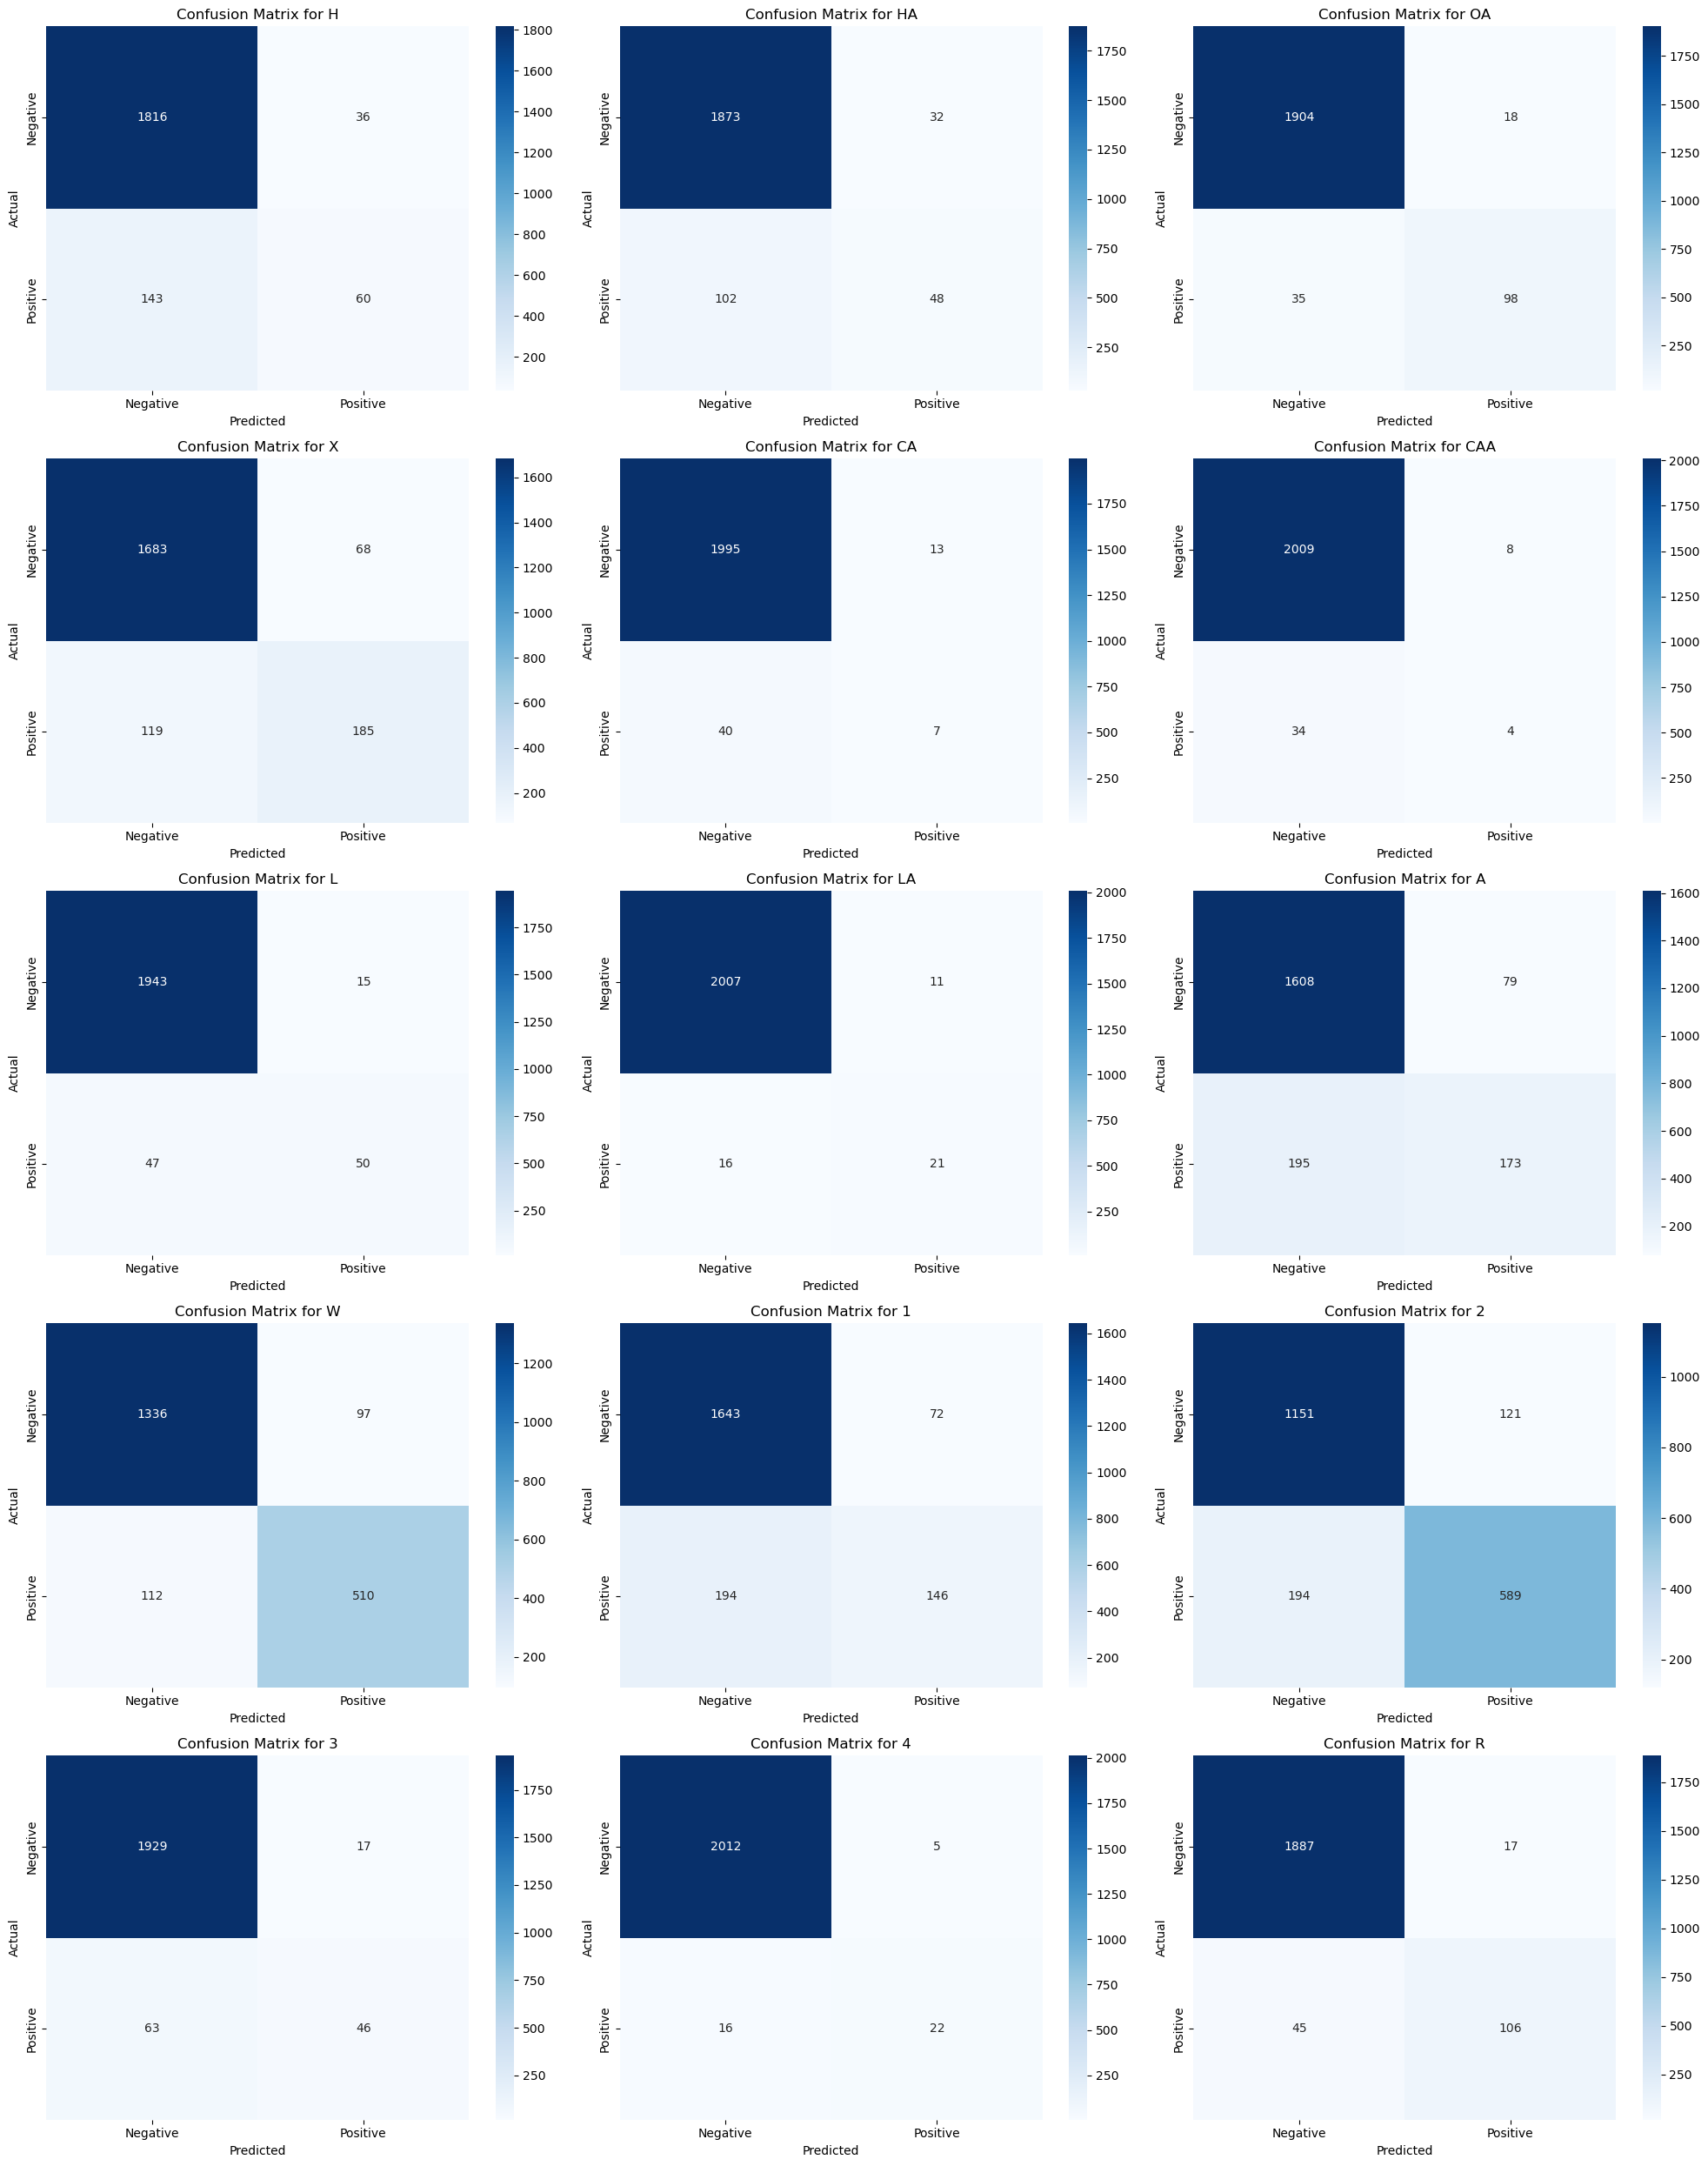

C:\Users\prana\AppData\Local\Temp\ipykernel_15600\4036798854.py:40: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=accuracy_per_label, y=LABELS, palette='viridis')


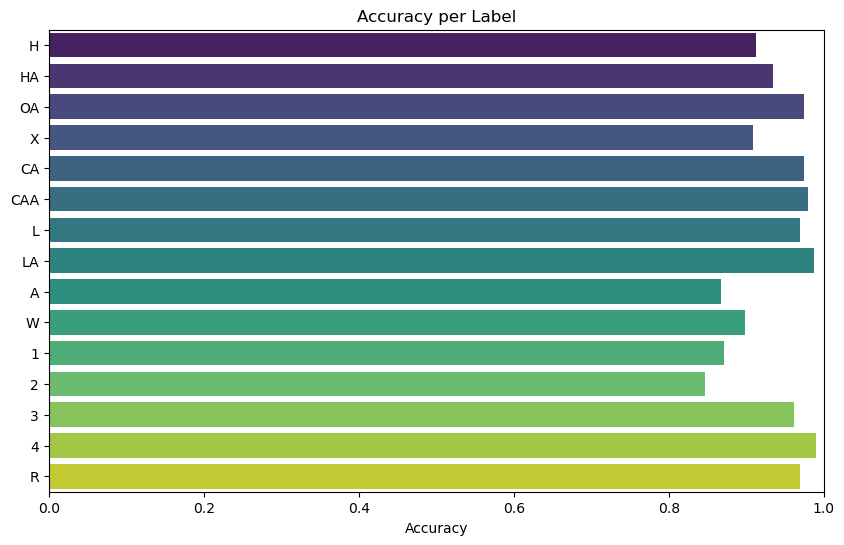

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import multilabel_confusion_matrix, classification_report

# After your existing code...

# Step 8: Predict on test set
y_pred = stacking_ensemble.predict(X_test)

# Step 9: Generate classification report
print("\n📊 Classification Report:")
print(classification_report(y_test, y_pred, target_names=LABELS, zero_division=0))

# Step 10: Generate and plot confusion matrices for each label
conf_matrices = multilabel_confusion_matrix(y_test, y_pred)

plt.figure(figsize=(20, 25))
for i, (matrix, label) in enumerate(zip(conf_matrices, LABELS)):
    plt.subplot(5, 3, i+1)
    sns.heatmap(matrix, annot=True, fmt='d', cmap='Blues', 
                xticklabels=['Negative', 'Positive'], 
                yticklabels=['Negative', 'Positive'])
    plt.title(f'Confusion Matrix for {label}')
    plt.ylabel('Actual')
    plt.xlabel('Predicted')

plt.tight_layout()
plt.savefig('multi_label_confusion_matrices.png')
plt.show()

# Step 11: Optional - Create a summary confusion matrix
# For multi-label, we can create an overall accuracy heatmap
accuracy_per_label = []
for label in LABELS:
    correct = ((y_test[label] == y_pred[:, LABELS.index(label)])).sum()
    total = len(y_test)
    accuracy_per_label.append(correct/total)

plt.figure(figsize=(10, 6))
sns.barplot(x=accuracy_per_label, y=LABELS, palette='viridis')
plt.title('Accuracy per Label')
plt.xlabel('Accuracy')
plt.xlim(0, 1)
plt.savefig('label_accuracy_summary.png')
plt.show()

c:\Users\prana\anaconda3\envs\tds\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\prana\anaconda3\envs\tds\lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
[WinError 2] The system cannot find the file specified
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "c:\Users\prana\anaconda3\envs\tds\lib\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
  File "c:\Users\prana\anaconda3\envs\tds\lib\subprocess.py", line 505, in run
    with Popen(*popenargs, **kwargs) as process:
  File "c:\Users\prana\anaconda3\envs\tds\lib\subprocess.py", line 951, in __init__
    self._execute_

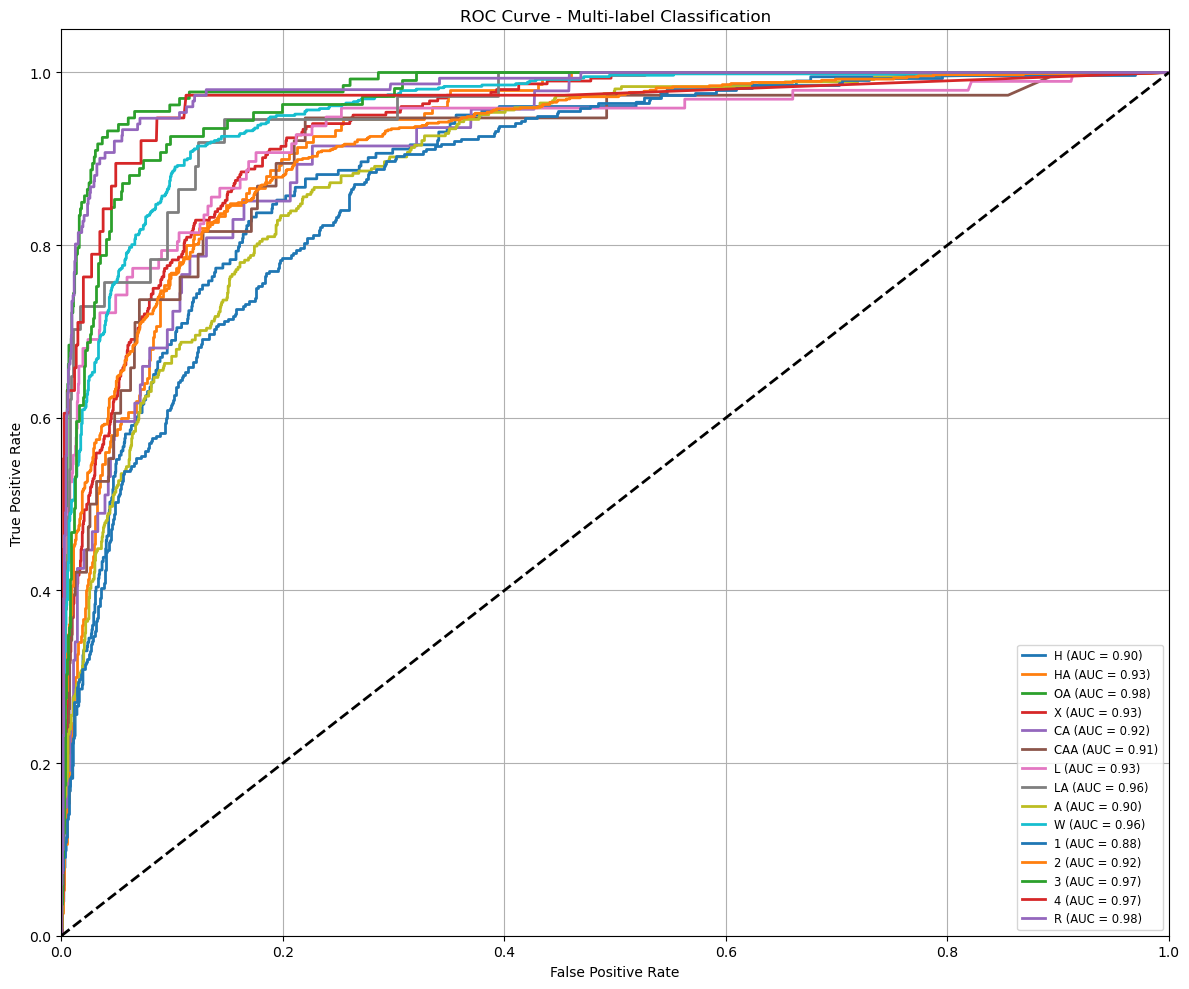

In [6]:
from sklearn.metrics import roc_curve, auc, roc_auc_score
import matplotlib.pyplot as plt
from sklearn.preprocessing import label_binarize
# Ensure predicted probabilities are available
y_score = stacking_ensemble.predict_proba(X_test)

# Reshape predict_proba output: list of arrays -> 2D array [n_samples, n_labels]
y_score_matrix = np.array([probs[:, 1] for probs in y_score]).T  # Keep positive class probs

# Binarize labels (though already 0/1, ensures correct format)
y_test_bin = y_test.to_numpy()

# Plot ROC for each class
plt.figure(figsize=(12, 10))
for i, label in enumerate(LABELS):
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_score_matrix[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=2, label=f'{label} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Multi-label Classification')
plt.legend(loc='lower right', fontsize='small')
plt.grid(True)
plt.tight_layout()
plt.show()

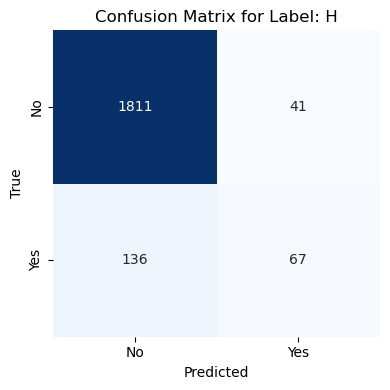

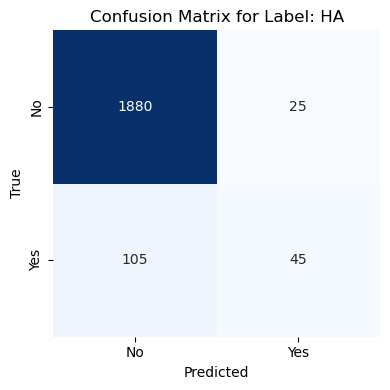

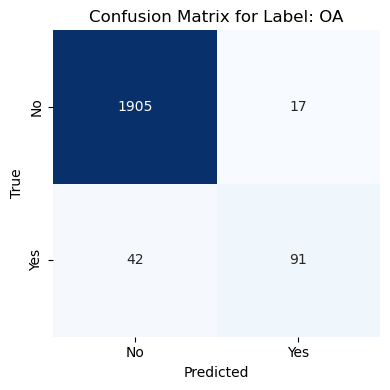

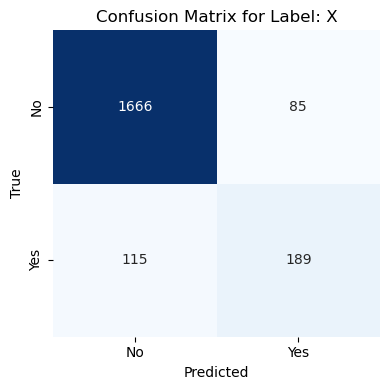

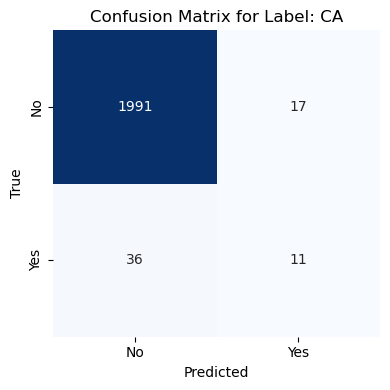

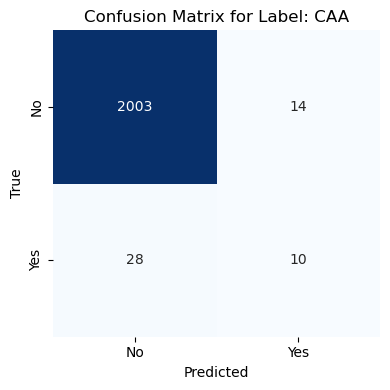

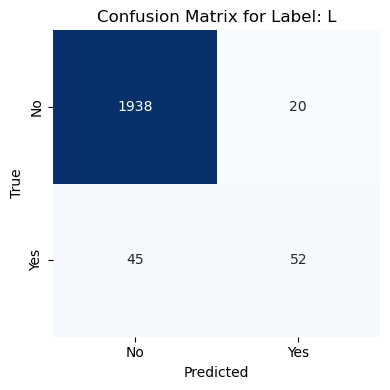

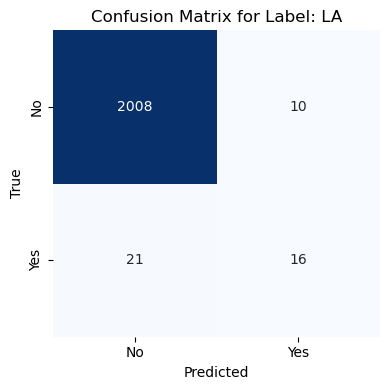

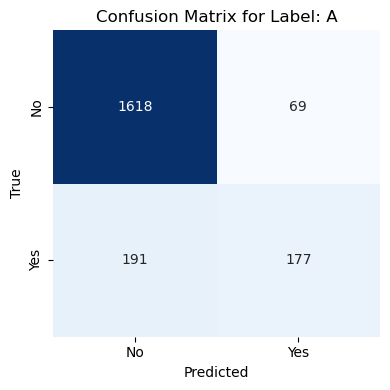

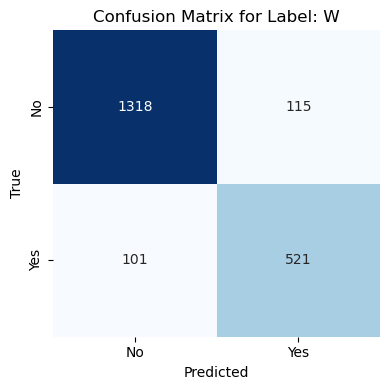

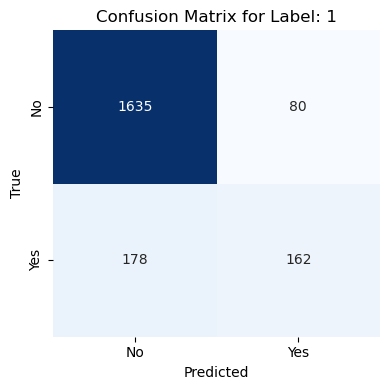

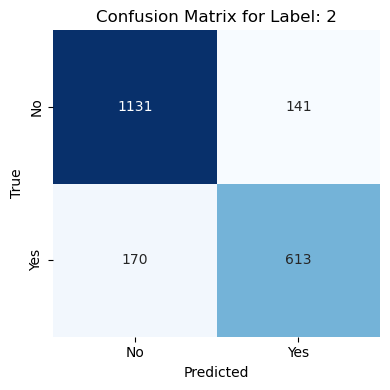

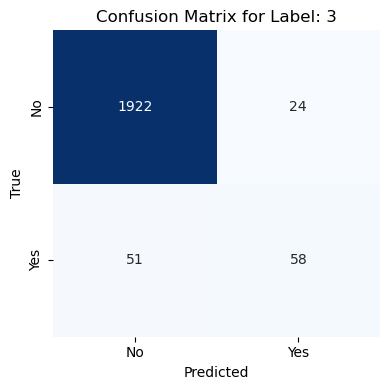

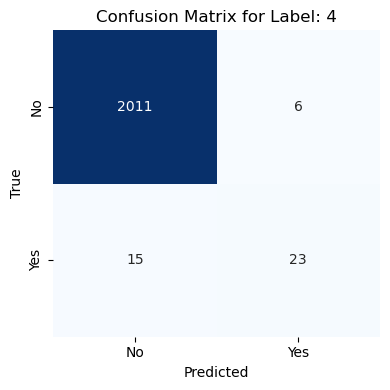

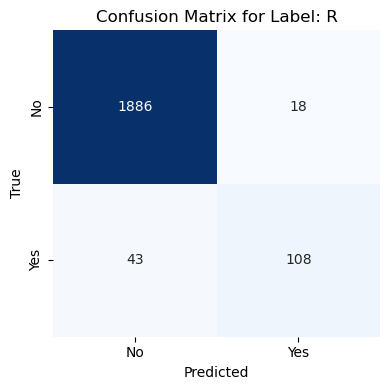

In [7]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Convert predictions to DataFrame for easier handling
y_pred_df = pd.DataFrame(y_pred, columns=LABELS) if isinstance(y_pred, np.ndarray) else pd.DataFrame(y_pred, columns=LABELS)

# Plot confusion matrix for each label
for label in LABELS:
    cm = confusion_matrix(y_test[label], y_pred_df[label])
    
    plt.figure(figsize=(4, 4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False, xticklabels=["No", "Yes"], yticklabels=["No", "Yes"])
    plt.title(f"Confusion Matrix for Label: {label}")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.tight_layout()
    plt.show()


In [9]:
from sklearn.metrics import accuracy_score, roc_auc_score

# Convert y_pred to DataFrame if needed
y_pred_df = pd.DataFrame(y_pred, columns=LABELS) if isinstance(y_pred, np.ndarray) else pd.DataFrame(y_pred, columns=LABELS)

print("🔎 Accuracy & AUC for Each Label:\n")
label_accuracies = {}
label_aucs = {}
s = 0
i = 0
for label in LABELS:
    i += 1
    acc = accuracy_score(y_test[label], y_pred_df[label])
    s += acc
    try:
        auc = roc_auc_score(y_test[label], y_pred_df[label])
    except ValueError:
        auc = float('nan')  # If AUC cannot be computed (e.g. only one class present)

    label_accuracies[label] = acc
    label_aucs[label] = auc

    print(f"{label:>3} | Accuracy: {acc:.4f} | AUC: {auc:.4f}")

# Macro and micro averages (optional)
try:
    macro_auc = roc_auc_score(y_test, y_pred_df, average='macro')
    micro_auc = roc_auc_score(y_test, y_pred_df, average='micro')
    print(f"\n🌐 Macro AUC: {macro_auc:.4f}")
    print(f"🌍 Micro AUC: {micro_auc:.4f}")
except ValueError:
    print("\n⚠️ AUC could not be computed for all labels due to class imbalance.")

print(s/i)


🔎 Accuracy & AUC for Each Label:

  H | Accuracy: 0.9139 | AUC: 0.6540
 HA | Accuracy: 0.9367 | AUC: 0.6434
 OA | Accuracy: 0.9713 | AUC: 0.8377
  X | Accuracy: 0.9027 | AUC: 0.7866
 CA | Accuracy: 0.9742 | AUC: 0.6128
CAA | Accuracy: 0.9796 | AUC: 0.6281
  L | Accuracy: 0.9684 | AUC: 0.7629
 LA | Accuracy: 0.9849 | AUC: 0.7137
  A | Accuracy: 0.8735 | AUC: 0.7200
  W | Accuracy: 0.8949 | AUC: 0.8787
  1 | Accuracy: 0.8745 | AUC: 0.7149
  2 | Accuracy: 0.8487 | AUC: 0.8360
  3 | Accuracy: 0.9635 | AUC: 0.7599
  4 | Accuracy: 0.9898 | AUC: 0.8011
  R | Accuracy: 0.9703 | AUC: 0.8529

🌐 Macro AUC: 0.7469
🌍 Micro AUC: 0.8009
0.9364476885644769
